<a href="https://colab.research.google.com/github/kleineidam/LeafTransport/blob/main/ants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import numpy as np
from matplotlib import pyplot as plt

# No memory

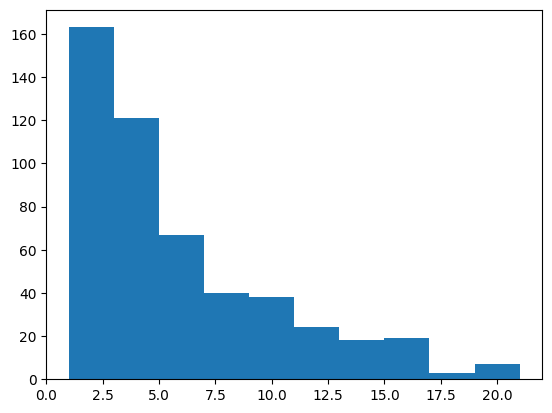

In [41]:
leaves = np.zeros(500)
leaf_moves = np.zeros_like(leaves)
for i in range(len(leaves)):
    for t in np.arange(100):
        #step forward
        leaves[i] += 1
        if np.random.randint(0,100) > 80:
            # DROP LEAF
            break

plt.hist(leaves);

# Memory

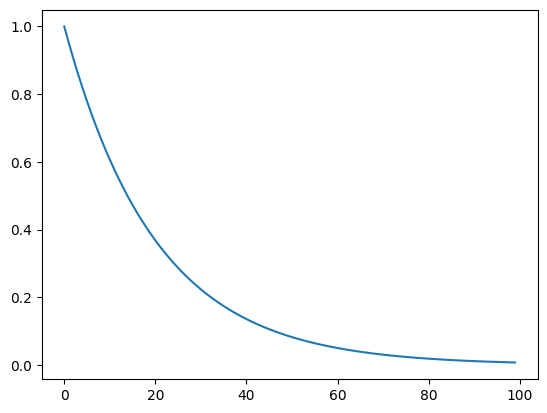

In [ ]:
t = np.arange(100)
plt.plot(t, np.exp(-t/20))

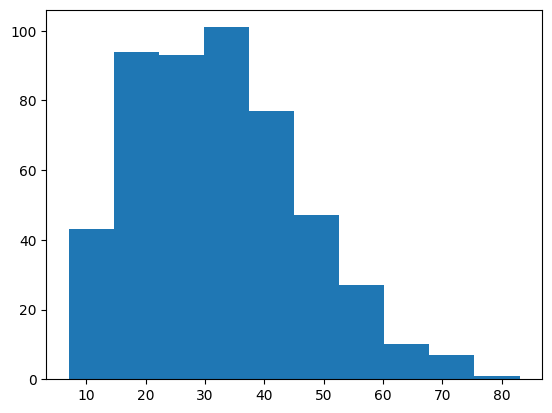

In [ ]:
leaves = np.zeros(500)
for i in range(len(leaves)):

    for t in np.arange(100):
        #step forward
        leaves[i] += 1
        motivation = 100 * np.exp(-t/500)
        if np.random.randint(0,100) > motivation:
            # DROP LEAF
            break

plt.hist(leaves);

# Reuptake and memory

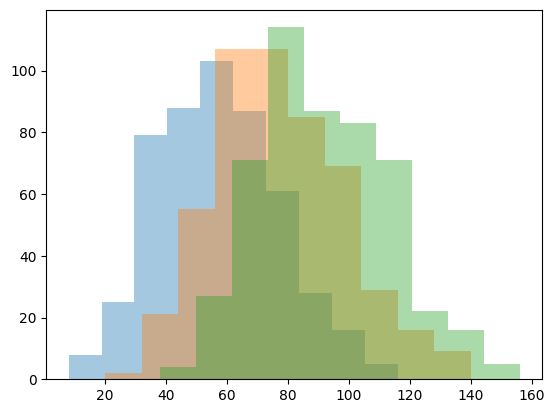

In [ ]:
leaves = np.zeros(500)

leaf_moves = np.zeros_like(leaves)
for t in np.arange(1000):
    for i in range(len(leaves)):
        if leaf_moves[i]:
            #step forward
            leaves[i] += 1
            # demotivator
            motivation = 100 * np.exp(-t/500)
            if  motivation < np.random.randint(0,100):
                # DROP LEAF
                leaf_moves[i] = False
        else:
            if np.random.randint(0,100) > 95:
                leaf_moves[i] = True

    if t%300==299:
        plt.hist(leaves, alpha=0.4);
        #print(t)

**Playground**

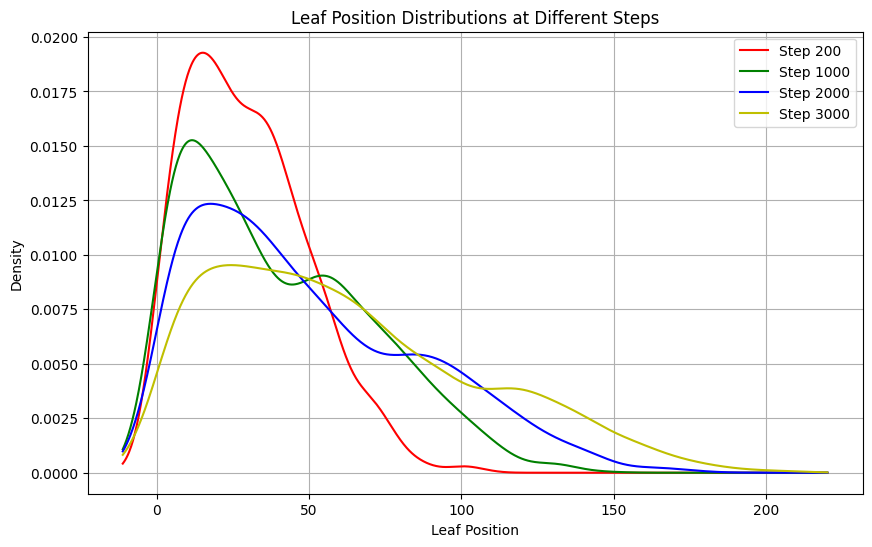

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Initial leaf setup
leaves = np.zeros(500)
leaf_moves = np.zeros_like(leaves, dtype=bool)

# Parameters for new leaf generation
generation_interval = 50
leaves_per_generation = 50
generation_mean = 0                # Keep around zero
generation_std = 0.5               # Small spread

# Checkpoints to store snapshots
checkpoints = [199, 999, 1999, 2999]
leaf_positions_at_checkpoints = []

for t in range(3000):
    motivation = 100 * np.exp(-t / 450)

    # Move active leaves
    moving = leaf_moves
    leaves[moving] += 1

    # Drop some moving leaves
    drop_mask = np.random.randint(0, 100, size=moving.sum()) > motivation
    leaf_moves[np.where(moving)[0][drop_mask]] = False

    # Randomly activate stationary leaves
    start_mask = (~leaf_moves) & (np.random.randint(0, 100, size=len(leaves)) > 96)
    leaf_moves[start_mask] = True

    # Generate new leaves near zero every interval
    if t % generation_interval == 0:
        new_positions = np.random.normal(loc=0, scale=generation_std, size=leaves_per_generation)
        leaves = np.concatenate([leaves, new_positions])
        leaf_moves = np.concatenate([leaf_moves, np.zeros(leaves_per_generation, dtype=bool)])

    if t in checkpoints:
        leaf_positions_at_checkpoints.append(leaves.copy())

# Plot the KDEs
plt.figure(figsize=(10, 6))

colors = ['r', 'g', 'b', 'y']
labels = [f"Step {cp + 1}" for cp in checkpoints]
x_vals = np.linspace(leaves.min() - 10, leaves.max() + 10, 1100)

for i, positions in enumerate(leaf_positions_at_checkpoints):
    kde = gaussian_kde(positions)
    plt.plot(x_vals, kde(x_vals), color=colors[i], label=labels[i])

plt.title("Leaf Position Distributions at Different Steps")
plt.xlabel("Leaf Position")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()
